<a href="https://colab.research.google.com/github/Chinwe-MC/Tumor-detection/blob/main/Tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files

# Upload your dataset files
uploaded = files.upload()

# Extract the uploaded files
for filename in uploaded.keys():
    print('Uploaded file:', filename)
    # Perform further processing as needed


Saving Brain_Dataset_Project.zip to Brain_Dataset_Project.zip
Uploaded file: Brain_Dataset_Project.zip


In [5]:
import zipfile
import os

# Path to the uploaded zip file
zip_file_path = '/content/Brain_Dataset_Project.zip'

# Directory to extract the files to
extracted_folder_path = '/content/extracted_folder'

# Create a directory to extract the files to
os.makedirs(extracted_folder_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# List the contents of the extracted folder
extracted_files = os.listdir(extracted_folder_path)
print("Extracted files:", extracted_files)


Extracted files: ['Brain_Dataset_Project']


In [6]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import cv2
import random
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import FileLink, display

In [7]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#e9eef2'}, style='darkgrid')

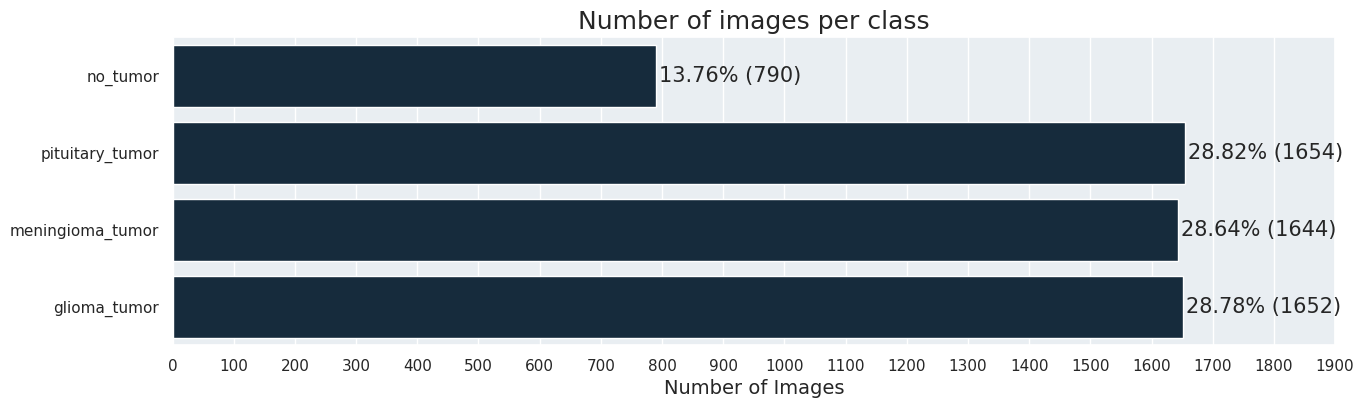

In [8]:
# import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define the directory where the image folders are located
base_dir = '/content/extracted_folder/Brain_Dataset_Project/Training'

# Obtain class names from the folder names in base_dir
classes = [folder_name for folder_name in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder_name))]

# Counting the number of images in each folder
counts = []
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    counts.append(len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]))

# Calculating the total number of images
total_count = sum(counts)

# Calculating the percentages
percentages = [(count / total_count) * 100 for count in counts]

# Set the figure size
plt.figure(figsize=(15, 4))

# Create a horizontal bar plot
ax = sns.barplot(y=classes, x=counts, orient='h', color='#102C42')

# Set x-axis interval (adjust as needed)
ax.set_xticks(range(0, max(counts) + 1, 1000))

# Annotate each bar with the count and percentage
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2.,
            '{:1.2f}% ({})'.format(percentages[i], counts[i]),
            va="center", fontsize=15)

# Set the x-label for the plot
plt.xlabel('Number of Images', fontsize=14)

# Set x-axis interval
ax.set_xticks(range(0, max(counts) + 300, 100))

# Set the title and show the plot
plt.title("Number of images per class", fontsize=18)
plt.show()


In [9]:
# Lists to store heights and widths of all images
heights = []
widths = []

# Initialize sets to store unique dimensions
unique_dims = set()

# Loop over each class and their respective images
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            # Add the dimensions (height, width, channels) to the set
            unique_dims.add((img.shape[0], img.shape[1]))

            # Append heights and widths for statistical calculations
            heights.append(img.shape[0])
            widths.append(img.shape[1])

# Check if all images have the same dimension
if len(unique_dims) == 1:
    print(f"All images have the same dimensions: {list(unique_dims)[0]}")
else:
    print(f"There are {len(unique_dims)} different image dimensions in the dataset.")
    print(f"Min height: {min(heights)}, Max height: {max(heights)}, Mean height: {np.mean(heights):.2f}")
    print(f"Min width: {min(widths)}, Max width: {max(widths)}, Mean width: {np.mean(widths):.2f}")

All images have the same dimensions: (256, 256)


In [10]:
import os
import cv2

# Function to resize images in a directory and replace the original images
def resize_and_replace(base_dir, target_size):
    # Loop over each class and their respective images
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)

        # Loop through the images in the class directory
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)

            # Read the original image
            img = cv2.imread(img_path)

            # Resize the image
            resized_img = cv2.resize(img, target_size)

            # Replace the original image with the resized one
            cv2.imwrite(img_path, resized_img)

# Set your target size (e.g., (224, 224) for a common image size)
target_size = (256, 256)

# Call the resize function to replace the original images
resize_and_replace(base_dir, target_size)

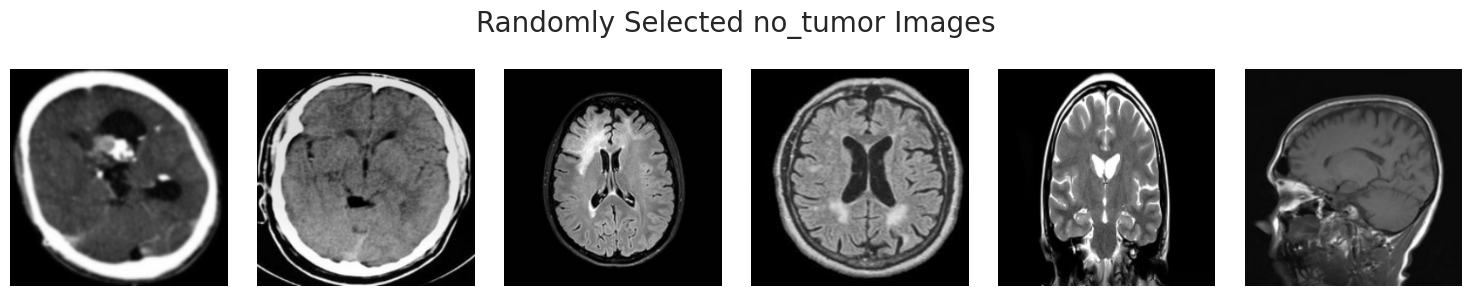

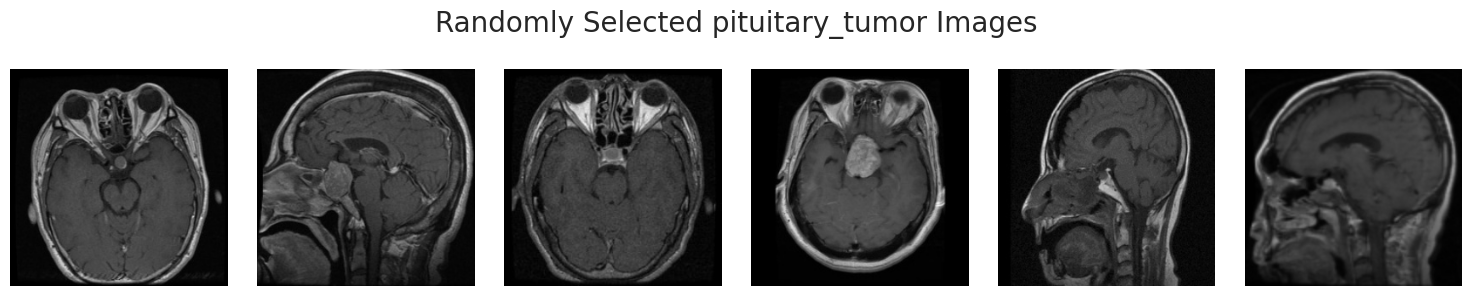

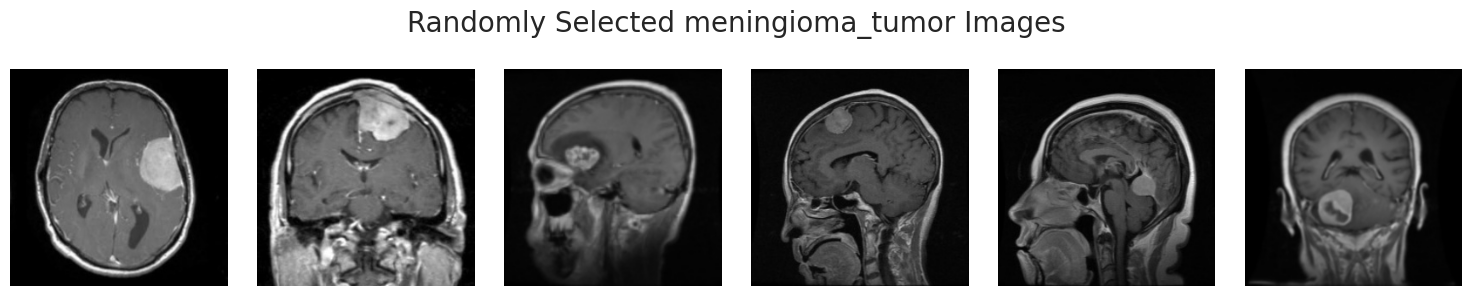

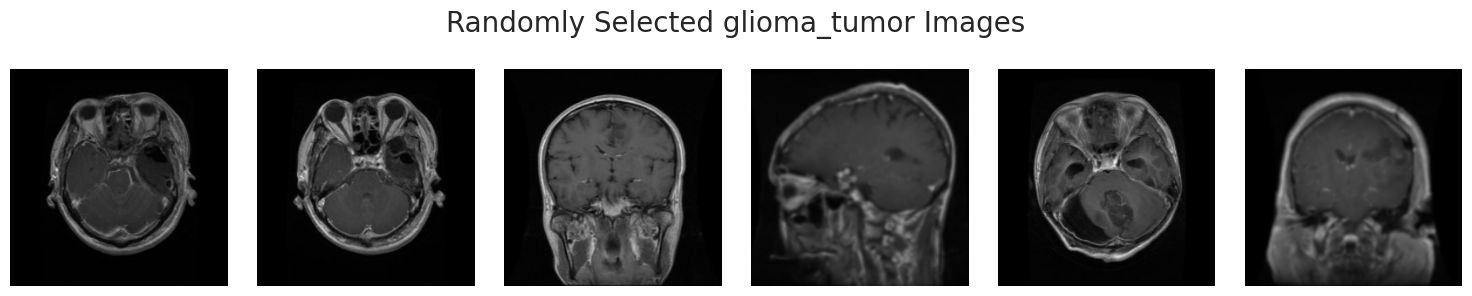

In [11]:
# Function to plot images
def plot_images(images, title):
    plt.figure(figsize=(15, 3))
    for i, img_path in enumerate(images):
        plt.subplot(1, 6, i+1)  # 1x5 subplot
        img = cv2.imread(img_path)
        # Convert the BGR image to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Setting the random seed for reproducibility
np.random.seed(42)

# Loop over each class and plot random images
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    random_images = np.random.choice(all_images, 6, replace=False)  # Choose 6 images randomly
    plot_images(random_images, f"Randomly Selected {class_name} Images")

In [12]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop over each class and append the image file paths with their respective labels to the data list
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    data.extend([(os.path.join(folder_path, filename), class_name) for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename))])

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

filepath     label
0  /content/extracted_folder/Brain_Dataset_Projec...  no_tumor
1  /content/extracted_folder/Brain_Dataset_Projec...  no_tumor
2  /content/extracted_folder/Brain_Dataset_Projec...  no_tumor
3  /content/extracted_folder/Brain_Dataset_Projec...  no_tumor
4  /content/extracted_folder/Brain_Dataset_Projec...  no_tumor

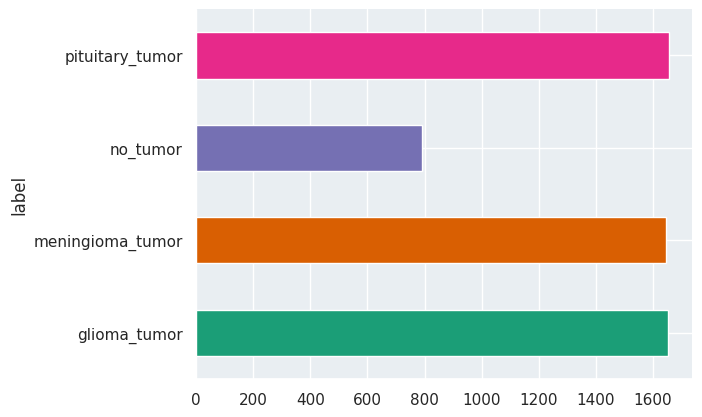

In [10]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
print("Total number of images:", df.shape[0])

Total number of images: 5740


In [14]:
# Deleting unnecessary variables to free up memory
del data, all_images

In [15]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Display the shape of the training and validation sets
print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)

# Deleting the original DataFrame to free up memory
del df

Training data shape: (4592, 2)
Validation data shape: (1148, 2)


In [16]:
# Display the first few rows of the train DataFrame
train_df.head(10)

filepath             label
4330  /content/extracted_folder/Brain_Dataset_Projec...      glioma_tumor
3754  /content/extracted_folder/Brain_Dataset_Projec...  meningioma_tumor
2064  /content/extracted_folder/Brain_Dataset_Projec...   pituitary_tumor
4831  /content/extracted_folder/Brain_Dataset_Projec...      glioma_tumor
2675  /content/extracted_folder/Brain_Dataset_Projec...  meningioma_tumor
5337  /content/extracted_folder/Brain_Dataset_Projec...      glioma_tumor
5356  /content/extracted_folder/Brain_Dataset_Projec...      glioma_tumor
1730  /content/extracted_folder/Brain_Dataset_Projec...   pituitary_tumor
752   /content/extracted_folder/Brain_Dataset_Projec...          no_tumor
5524  /content/extracted_folder/Brain_Dataset_Projec...      glioma_tumor

In [17]:
def add_gaussian_noise(image, mean=0, std=0.05):
    """ Add Gaussian noise to an image """
    gauss = np.random.normal(mean, std, image.shape)
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

In [18]:
def apply_blur(image, kernel_size=5):
    """ Apply Gaussian blur to an image """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [19]:
def downsample_upsample(image, scale_percent=50):
    """ Downsample and then upsample an image """
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return cv2.resize(resized, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)

In [20]:
def count_images(dataframe):
    """ Function to count the total number of images in a DataFrame """
    return dataframe.shape[0]

In [21]:
# Count and print the number of images in the training and validation sets before the modifications
total_train_images = count_images(train_df)
total_val_images = count_images(val_df)

print(f"Total number of training images: {total_train_images}")
print(f"Total number of validation images: {total_val_images}")

Total number of training images: 4592
Total number of validation images: 1148


In [22]:
def augment_images(dataframe, base_dir):
    modified_data = []

    for _, row in dataframe.iterrows():
        img_path = row['filepath']
        label = row['label']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Randomly apply one or more degradation methods
        choices = ['noise', 'blur', 'downsample']
        chosen_methods = random.sample(choices, k=random.randint(1, len(choices)))

        if 'noise' in chosen_methods:
            img = add_gaussian_noise(img)
        if 'blur' in chosen_methods:
            img = apply_blur(img)
        if 'downsample' in chosen_methods:
            img = downsample_upsample(img)

        # Save the new image with a modified name
        directory, filename = os.path.split(img_path)
        new_img_path = os.path.join(directory, f"modified_{filename}")
        cv2.imwrite(new_img_path, img)

        # Append the new image path and its label to the list
        modified_data.append((new_img_path, label))

    # Create a DataFrame with the modified images and their respective labels
    modified_images_df = pd.DataFrame(modified_data, columns=['filepath', 'label'])

    # Return the updated DataFrame with both original and modified images
    return pd.concat([dataframe, modified_images_df], ignore_index=True)

In [23]:
# Apply augmentation and update the training and validation datasets
train_df = augment_images(train_df, base_dir)
val_df = augment_images(val_df, base_dir)

In [24]:
# Count and print the number of images in the training and validation sets after the modifications
total_train_images = count_images(train_df)
total_val_images = count_images(val_df)

print(f"Total number of training images: {total_train_images}")
print(f"Total number of validation images: {total_val_images}")

Total number of training images: 9184
Total number of validation images: 2296


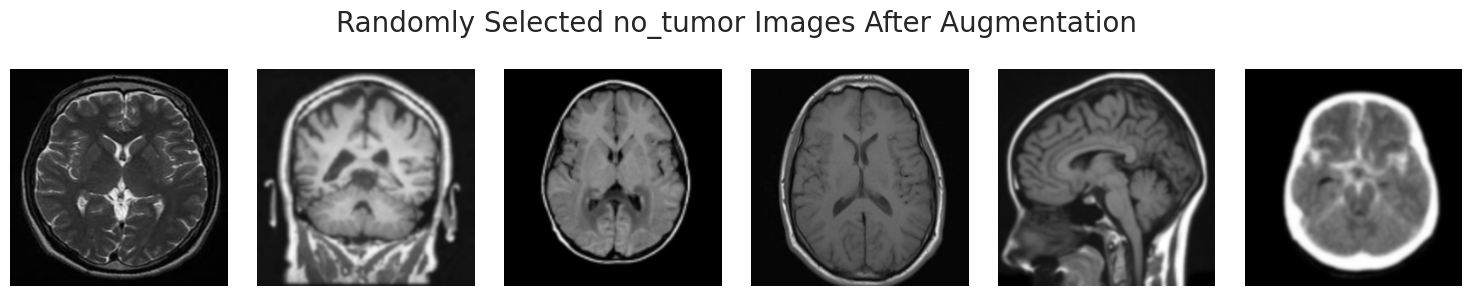

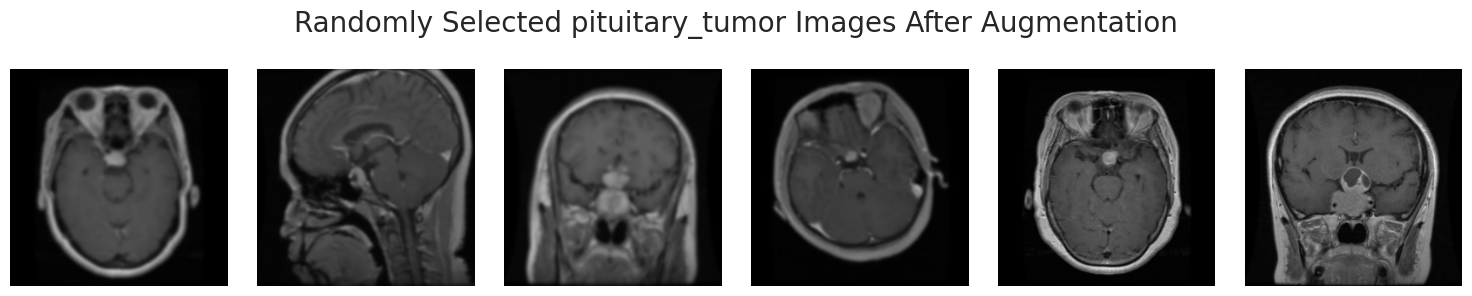

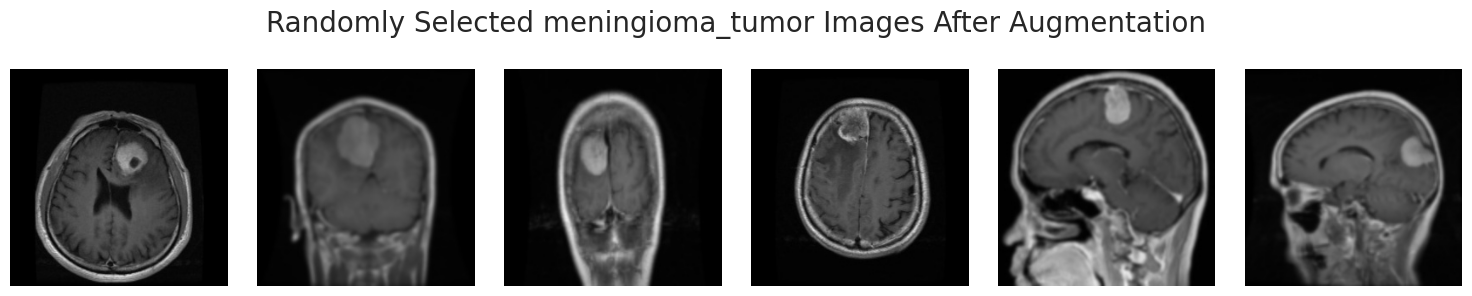

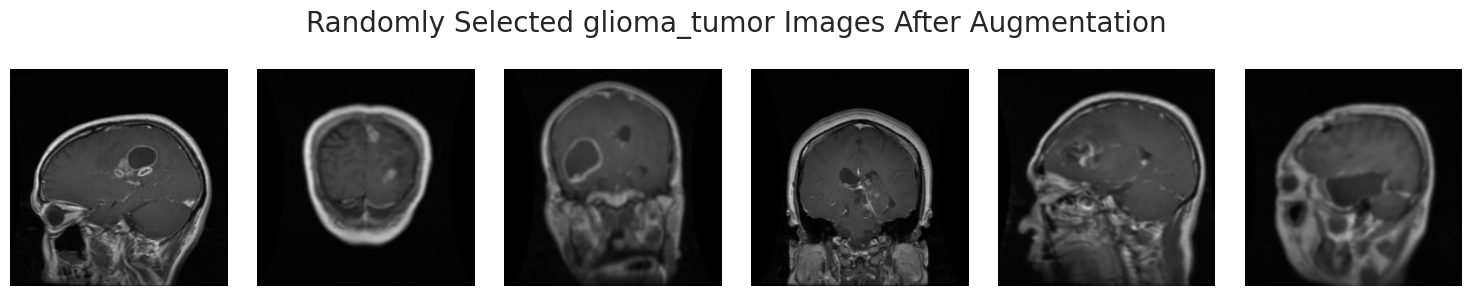

In [25]:
# Loop over each class and plot random images
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    random_images = np.random.choice(all_images, 6, replace=False)  # Choose 6 images randomly
    plot_images(random_images, f"Randomly Selected {class_name} Images After Augmentation")

In [26]:
def create_data_generators(train_df, val_df, preprocessing_function=None, batch_size=32, image_dimensions=(224, 224)):
    """
    Creates and returns training and validation data generators with optional preprocessing.

    Parameters:
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - preprocessing_function (function, optional): Preprocessing function specific to a model. Defaults to None.
    - batch_size (int, optional): Number of images per batch for the generators. Defaults to 32.
    - image_dimensions (tuple, optional): Dimensions to which the images will be resized (height, width). Defaults to (224, 224).

    Returns:
    - train_generator (ImageDataGenerator): Generator for training data.
    - val_generator (ImageDataGenerator): Generator for validation data.

    Notes:
    - The validation generator does not use any augmentations.
    - If provided, the preprocessing function is applied to both generators.
    """

    # Define the training data generator with appropriate augmentations
    train_datagen = ImageDataGenerator(
        rotation_range=20,                           # Rotate images by up to 20 degrees
        width_shift_range=0.10,                      # Shift images horizontally by up to 10% of their width
        height_shift_range=0.10,                     # Shift images vertically by up to 10% of their height
        zoom_range=0.10,                             # Zoom in/out by up to 10%
        horizontal_flip=True,                        # Allow horizontal flipping
        preprocessing_function=preprocessing_function
    )

    # Define the validation data generator without any augmentations
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function
    )

    # Create an iterable generator for training data
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,                 # DataFrame containing training data
        x_col="filepath",                   # Column with paths to image files
        y_col="label",                      # Column with image labels
        target_size=image_dimensions,       # Resize all images to size of 224x224
        batch_size=batch_size,              # Number of images per batch
        class_mode='categorical',           # Specify multi-class classification task
        seed=42,                            # Seed for random number generator to ensure reproducibility
        shuffle=True                        # Shuffle the data to ensure the model gets a randomized batch during training
    )

    # Create an iterable generator for validation data
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,                   # DataFrame containing validation data
        x_col="filepath",
        y_col="label",
        target_size=image_dimensions,
        batch_size=batch_size,
        class_mode='categorical',           # Specify multi-class classification task
        seed=42,
        shuffle=False                       # Shuffling not necessary for validation data
    )

    # Return the training and validation generators
    return train_generator, val_generator

In [27]:
# Create the data generators
train_generator, val_generator = create_data_generators(train_df, val_df, preprocessing_function=preprocess_input)

# Fetch a batch of images and labels
batch_images, batch_labels = next(train_generator)

# Check the shape of the first image in the batch
print("Shape of the first image in the batch:", batch_images[0].shape)

Found 9184 validated image filenames belonging to 4 classes.
Found 2296 validated image filenames belonging to 4 classes.
Shape of the first image in the batch: (224, 224, 3)


In [28]:
# Retrieve the class names
class_indices = train_generator.class_indices

# Sorting the class indices to get the list of class names in the correct order
class_names = sorted(class_indices, key=class_indices.get)
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [29]:
# Load the pre-trained ResNet50V2 model without the top layer
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94668760/94668760 [==============================] - 0s 0us/step


In [30]:
# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout added to prevent overfitting
x = Dense(4, activation='softmax')(x)  # Output layer for multi-class classification

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.761386 to fit



In [32]:
# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [33]:
def train_model(model, train_df, val_df, preprocessing_function, image_dimensions=(224, 224), batch_size=32, num_epochs=50):
    """
    Creates and returns training and validation data generators with optional preprocessing and augmentation.

    Parameters:
    - model: Model, a compiled instance of a Keras model to be trained.
    - train_df: DataFrame, the training data.
    - val_df: DataFrame, the validation data.
    - preprocessing_function: function, preprocessing function to be applied to input data.
    - image_dimensions: tuple, dimensions of the images (width, height).
    - batch_size: int, number of samples per batch of computation.
    - num_epochs: int, number of epochs to train the model.

    Returns:
    - model: The trained model instance.
    - history: A History object containing the training history.
    - val_generator: The validation data generator.
    """

    # Create data generators
    train_generator, val_generator = create_data_generators(train_df, val_df, preprocessing_function, batch_size, image_dimensions)

    # Define the callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=num_epochs,
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[reduce_lr, early_stopping]
    )

    return model, history, val_generator

In [ ]:
# Fine-tune the model
model, history, val_generator = train_model(model, train_df, val_df, preprocessing_function=preprocess_input, num_epochs=50)

Found 9184 validated image filenames belonging to 4 classes.
Found 2296 validated image filenames belonging to 4 classes.
Epoch 1/50
287/287 [==============================] - 182s 512ms/step - loss: 0.3050 - accuracy: 0.8878 - val_loss: 0.2704 - val_accuracy: 0.8955 - lr: 1.0000e-04
Epoch 2/50
287/287 [==============================] - 146s 507ms/step - loss: 0.0999 - accuracy: 0.9628 - val_loss: 0.1339 - val_accuracy: 0.9543 - lr: 1.0000e-04
Epoch 3/50
287/287 [==============================] - 146s 509ms/step - loss: 0.0686 - accuracy: 0.9775 - val_loss: 0.0630 - val_accuracy: 0.9769 - lr: 1.0000e-04
Epoch 4/50
287/287 [==============================] - 147s 511ms/step - loss: 0.0520 - accuracy: 0.9834 - val_loss: 0.0499 - val_accuracy: 0.9843 - lr: 1.0000e-04
Epoch 5/50
287/287 [==============================] - 145s 506ms/step - loss: 0.0433 - accuracy: 0.9855 - val_loss: 0.0552 - val_accuracy: 0.9830 - lr: 1.0000e-04
Epoch 6/50
287/287 [==============================] - 150s 524m